## Dataset
**MNIST data** is a collection of 28x28 grayscale images; hence each pixel is a gray-level from 0-255.
## Task
You will consider digit classification on MNIST data, as a simple image understanding/machine learning
problem that is widely studied. The aim is to reverse the learning so that you are first interested in the problem
and thus will be more motivated to better learn about the possible approaches to the problem.

In [0]:
!pip install -q mlxtend

### Importing Data from local

In [2]:
from mlxtend.data import loadlocal_mnist
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import tree
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

#Imporating the Mnist Data that is downloaded from orginal source
# i.e. http://yann.lecun.com/exdb/mnist/

from google.colab import drive
drive.mount('/content/drive/')

# trainingImages, and trainingLabels
xTrain, yTrain = loadlocal_mnist(
        images_path='/content/drive/My Drive/Colab Notebooks/train-images-idx3-ubyte', 
        labels_path='/content/drive/My Drive/Colab Notebooks/train-labels-idx1-ubyte')

# testImages, and testLabels 
xTest, yTest = loadlocal_mnist(
        images_path='/content/drive/My Drive/Colab Notebooks/t10k-images-idx3-ubyte', 
        labels_path='/content/drive/My Drive/Colab Notebooks/t10k-labels-idx1-ubyte')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
print("xTrain initial shape: ", xTrain.shape)
print("yTrain initial shape: ", yTrain.shape)
print("xTest initial shape:  ", xTest.shape)
print("yTest initial shape:  ", yTest.shape)

xTrain initial shape:  (60000, 784)
yTrain initial shape:  (60000,)
xTest initial shape:   (10000, 784)
yTest initial shape:   (10000,)


### Checking few examples from train data

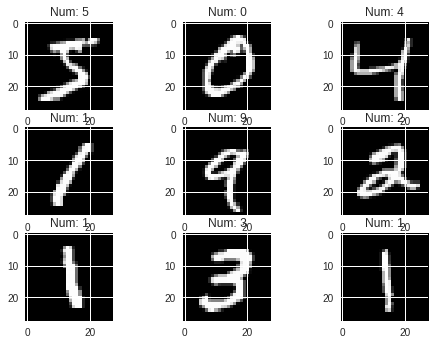

In [4]:
# inorder to view xTrain
x_train = xTrain.reshape(60000, 28, 28)
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(xTrain[i].reshape([28,28]), cmap='gray', interpolation='none')
    plt.title("Num: {}".format(yTrain[i]))

### Formating Training Data

In [0]:
# take 15% of the training data and use that for validation
# Taking first 15K as the to lower the calculation time
(trainData, valData, trainLabels, valLabels) = train_test_split(xTrain[:15000], yTrain[:15000], test_size=0.15, random_state=84)

### Creating Decision Tree Classifier

#### Deciding best min_samples_split

In [6]:
splitValues = range(2, 11, 2)
leafValues = range(2, 21, 1)

accuracyTreevalues = []

for x in splitValues :
    clf = tree.DecisionTreeClassifier(criterion="gini", min_samples_split=x)
    clf.fit(trainData, trainLabels)

    # evaluate the model and print the accuracies list
    score = clf.score(valData, valLabels)
    print("split=%d, accuracy=%.2f%%" % (x, score * 100))
    accuracyTreevalues.append(score)

split=2, accuracy=81.16%
split=4, accuracy=81.02%
split=6, accuracy=79.96%
split=8, accuracy=81.29%
split=10, accuracy=81.07%


In [7]:
# largest accuracy
# np.argmax returns the indices of the maximum values along an axis
i = np.argmax(accuracyTreevalues)
print("split=%d achieved highest accuracy of %.2f%% on validation data" % (splitValues[i], accuracyTreevalues[i] * 100))

split=8 achieved highest accuracy of 81.29% on validation data


#### Deciding best min_samples_leaf

In [8]:
leafValues = range(2, 21, 1)

accuracyLeafvalues = []

for x in leafValues :
    clf = tree.DecisionTreeClassifier(criterion="gini", min_samples_split=splitValues[i], min_samples_leaf=x)
    clf.fit(trainData, trainLabels)

    # evaluate the model and print the accuracies list
    score = clf.score(valData, valLabels)
    print("leaf=%d, accuracy=%.2f%%" % (x, score * 100))
    accuracyLeafvalues.append(score)

split=2, accuracy=80.67%
split=3, accuracy=80.58%
split=4, accuracy=81.24%
split=5, accuracy=81.16%
split=6, accuracy=81.16%
split=7, accuracy=81.02%
split=8, accuracy=80.84%
split=9, accuracy=80.76%
split=10, accuracy=81.16%
split=11, accuracy=80.67%
split=12, accuracy=80.22%
split=13, accuracy=80.71%
split=14, accuracy=80.58%
split=15, accuracy=80.40%
split=16, accuracy=80.40%
split=17, accuracy=80.00%
split=18, accuracy=79.96%
split=19, accuracy=79.56%
split=20, accuracy=79.11%


In [9]:
# largest accuracy
# np.argmax returns the indices of the maximum values along an axis
o = np.argmax(accuracyTreevalues)
print("split=%d achieved highest accuracy of %.2f%% on validation data" % (leafValues[o], accuracyLeafvalues[o] * 100))

split=5 achieved highest accuracy of 81.16% on validation data


#### Trying with best performence parameters

In [10]:
clf = tree.DecisionTreeClassifier(criterion="gini",min_samples_split=splitValues[i], min_samples_leaf=leafValues[o])
clf.fit(trainData, trainLabels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [11]:
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold


# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes"
      % n_nodes)

nodeDepth = math.log((n_nodes - 1),2)-1

print("The min depth of the tree structure is %s"
      % math.floor(nodeDepth))

print("Root Node: go to node %s if pixel[:, %s] <= %s else to "
               "node %s."
              % (children_left[0],
                 feature[0],
                 threshold[0],
                 children_right[0],
                 ))



The binary tree structure has 1297 nodes
The min depth of the tree structure is 9
Root Node: go to node 1 if pixel[:, 378] <= 128.5 else to node 684.


In [0]:
predictionRes = clf.predict(xTest)

In [13]:
accuracy = 100.0 * metrics.accuracy_score(yTest, predictionRes)
print("Overall Accuracy")
print(accuracy)

Overall Accuracy
81.63


In [14]:
report = metrics.classification_report(yTest.tolist(), predictionRes, digits=4)
# Evaluate performance of model for each of the digits
print("EVALUATION ON TESTING DATA")
print(report)

EVALUATION ON TESTING DATA
             precision    recall  f1-score   support

          0     0.8711    0.9449    0.9065       980
          1     0.8962    0.9507    0.9226      1135
          2     0.7769    0.7762    0.7765      1032
          3     0.7284    0.7861    0.7562      1010
          4     0.8107    0.8024    0.8066       982
          5     0.7260    0.7130    0.7195       892
          6     0.8379    0.8257    0.8318       958
          7     0.8615    0.8774    0.8694      1028
          8     0.8081    0.7002    0.7503       974
          9     0.8224    0.7572    0.7884      1009

avg / total     0.8157    0.8163    0.8151     10000



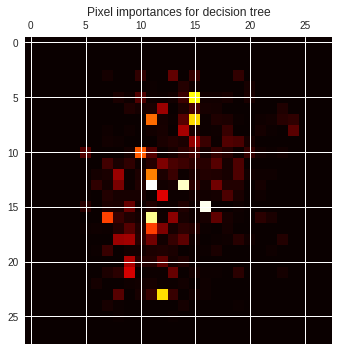

In [15]:
# Pixel importances on 28*28 image
importances = clf.feature_importances_
importances = importances.reshape((28, 28))

# Plot pixel importances
plt.matshow(importances, cmap=plt.cm.hot)
plt.title("Pixel importances for decision tree")
plt.show()

### Rescaling Data for additional classification

## Q1

a) Used 'gini' as criterion. Used min_samples_split and min_samples_leaf that gave highest accuracy on validation data. Other parameters are default. 


b) Pixel 378 in range of 784 is used in the root. As it has the highest value in pixel importance map, it should be strong determining factor.


c)


###  K-Nearest Neighbor Classification

#### Initialize the values of k for our k-NN classifier along with the list of accuracies for each value of k

In [16]:
kValues = range(1, 11, 2)

accuracyKvalues = []

for k in kValues:
    # train the classifier with the current value of `k`
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(trainData, trainLabels)

    # evaluate the model and print the accuracies list
    score = model.score(valData, valLabels)
    print("k=%d, accuracy=%.2f%%" % (k, score * 100))
    accuracyKvalues.append(score)

k=1, accuracy=95.78%
k=3, accuracy=95.38%
k=5, accuracy=95.20%
k=7, accuracy=95.02%
k=9, accuracy=95.02%


In [17]:
# largest accuracy
# np.argmax returns the indices of the maximum values along an axis
i = np.argmax(accuracyKvalues)
print("k=%d achieved highest accuracy of %.2f%% on validation data" % (kValues[i], accuracyKvalues[i] * 100))


k=1 achieved highest accuracy of 95.78% on validation data


#### Trying it on testing data with k value that gave highest accuracy

In [18]:
# Now that I know the best value of k, re-train the classifier
model = KNeighborsClassifier(n_neighbors=kValues[i])
model.fit(trainData, trainLabels)

# Predict labels for the test set
predictions = model.predict(xTest)

# Overall accuracy on testing data
accuracy = 100.0 * metrics.accuracy_score(yTest, predictions)
print("Overall Accuracy")
print(accuracy)

Overall Accuracy
95.07


In [19]:
# Evaluate performance of model for each of the digits
print("EVALUATION ON TESTING DATA")
print(classification_report(yTest, predictions))

EVALUATION ON TESTING DATA
             precision    recall  f1-score   support

          0       0.96      0.99      0.97       980
          1       0.95      0.99      0.97      1135
          2       0.98      0.93      0.96      1032
          3       0.93      0.94      0.94      1010
          4       0.96      0.94      0.95       982
          5       0.94      0.94      0.94       892
          6       0.97      0.98      0.97       958
          7       0.94      0.95      0.95      1028
          8       0.97      0.89      0.93       974
          9       0.91      0.94      0.93      1009

avg / total       0.95      0.95      0.95     10000



## Q2

a) Highest accuracy is achived with k = 1 which is %95.8 on validation data.


b) Traversed through different k values to find best performence.



### Naïve Bayes classifier using the univariate Gaussian distribution

In [20]:
nb = GaussianNB()
nb.fit(trainData, trainLabels)

GaussianNB(priors=None)

In [21]:
# Predict labels for the test set
predictions = nb.predict(xTest)

# Overall accuracy on testing data
accuracy = 100.0 * metrics.accuracy_score(yTest, predictions)
print("Overall Accuracy")
print(accuracy)

Overall Accuracy
56.779999999999994


In [22]:
# Evaluate performance of model for each of the digits
print("EVALUATION ON TESTING DATA")
print(classification_report(yTest, predictions))

EVALUATION ON TESTING DATA
             precision    recall  f1-score   support

          0       0.64      0.93      0.76       980
          1       0.70      0.96      0.81      1135
          2       0.91      0.30      0.46      1032
          3       0.72      0.34      0.46      1010
          4       0.84      0.20      0.33       982
          5       0.65      0.12      0.20       892
          6       0.65      0.91      0.76       958
          7       0.88      0.35      0.50      1028
          8       0.34      0.56      0.42       974
          9       0.39      0.93      0.55      1009

avg / total       0.67      0.57      0.53     10000



In [23]:
# Confusion Matrix
cm=metrics.confusion_matrix(predictions,yTest)
print(cm)

[[ 910    1  123  134   42  155   16    2   26    9]
 [   1 1095   53   90   24   48   34   25  164   22]
 [   5    2  314    6    4    2    6    1    3    3]
 [   4    3   71  341    4   20    1   15    7    6]
 [   3    0    7    4  200    5    1    6    7    6]
 [   9    2    4    4    7  108   10    1   19    1]
 [  26    8  242   60   82   40  872    4   16    1]
 [   1    0    6   10    9    4    0  355    5   15]
 [  12   19  193  264  126  416   17   22  545    8]
 [   9    5   19   97  484   94    1  597  182  938]]


## Q3

a) 56% accuracy on test data.


b)

### Gaussian Bayes classifier using the multivariate Gaussian distribution


In [0]:
from scipy.stats import multivariate_normal
class BayesClassifier:
    
    mu = None
    cov = None
    n_classes = None
    
    def __init__(self):
        a = None
    
    def pred(self,x):
        prob_vect = np.zeros(self.n_classes)
        
        for i in range(self.n_classes):
            
            
            mnormal = multivariate_normal(mean=bc.mu[i], cov=bc.cov[i])
            
            # We use uniform priors
            prior = 1./self.n_classes
            
            prob_vect[i] = prior*mnormal.pdf(x)
            sumatory = 0.
            for j in range(self.n_classes):
                mnormal = multivariate_normal(mean=bc.mu[j], cov=bc.cov[j])
                sumatory += prior*mnormal.pdf(x)
            prob_vect[i] = prob_vect[i]/sumatory
        return prob_vect
        
    def fit(self, X,y):
        self.mu = []
        self.cov = []
        
        self.n_classes = np.max(y)+1
        
        for i in range(self.n_classes):
            Xc = X[y==i]
            
            mu_c = np.mean(Xc, axis=0)
            self.mu.append(mu_c)
            
            cov_c = np.zeros((X.shape[1], X.shape[1]))
            for j in range( Xc.shape[0]):
                a = Xc[j].reshape((X.shape[1],1))
                b = Xc[j].reshape((1,X.shape[1]))
                cov_ci = np.multiply(a, b)
                cov_c = cov_c+cov_ci
            cov_c = cov_c/float(X.shape[0])
            self.cov.append(cov_c)
        self.mu = np.asarray(self.mu)
        self.cov = np.asarray(self.cov)

In [0]:
# Fit the classifier on the two-feature dataset

bc = BayesClassifier()

bc.fit(trainData, trainLabels)

## Q4

a)


b)

## Q5 - Report

I have evaluated the performance of decision tree, k-NN and Bayes classifiers (Gaussian Naïve Bayes and
Gaussian Bayes with general and shared covariance matrices) on the dataset MNIST. 
 
I used first 15K of the data as training and validation to have shorter runtimes when trainining the classifier.

We have obtained the best results with the Knn classifier , giving an accuracy of 95% on test data.

